In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env


In [2]:
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)

In [3]:
df.head(2)

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...


In [4]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [5]:
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [6]:
df.ip.value_counts().head()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
Name: ip, dtype: int64

In [7]:
df.ip.value_counts(normalize=True).head()

97.105.19.58      0.858595
173.173.113.51    0.075784
72.181.113.170    0.043867
72.181.105.81     0.017604
24.26.242.9       0.001503
Name: ip, dtype: float64

In [8]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [9]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()


,count,proba
97.105.19.58,11998,0.858595
173.173.113.51,1059,0.075784
72.181.113.170,613,0.043867
72.181.105.81,246,0.017604
24.26.242.9,21,0.001503


<Axes: >

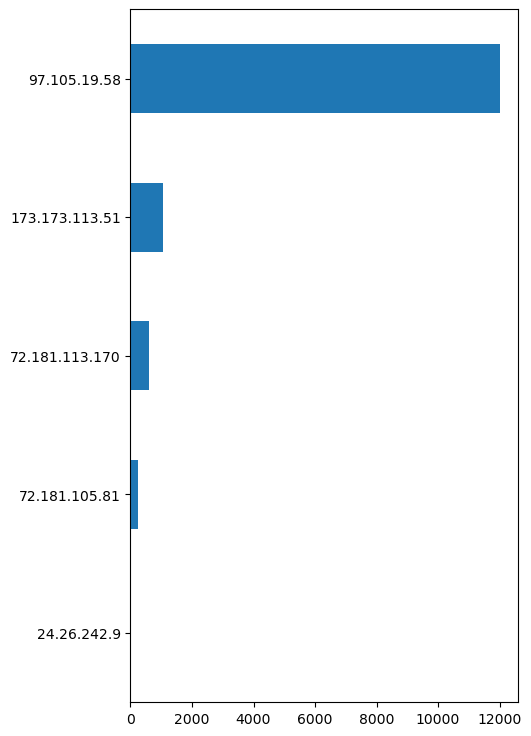

In [10]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [11]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [12]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
20,97.105.19.58,499,0.001167


In [13]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
19,97.105.19.58,200,0.998833
20,97.105.19.58,499,0.001167


In [14]:
df.groupby(['ip', 'status_code']).size()

ip              status_code
173.173.113.51  200             1059
24.26.242.9     200               21
3.88.129.158    200                1
3.92.201.136    200                1
34.207.64.242   200                1
34.229.70.250   200                1
35.174.209.2    200                1
35.175.171.137  200                2
45.23.250.16    200                1
52.87.230.102   200                2
52.90.165.200   200                1
52.91.30.150    200                1
54.145.52.184   200                1
54.172.14.223   200                1
68.201.219.223  200               21
70.121.214.34   200                2
72.181.105.81   200              246
72.181.113.170  200              611
                499                2
97.105.19.58    200            11984
                499               14
dtype: int64

In [15]:
p_a_and_b = df.groupby(['ip', 'status_code']).size()
p_a_and_b

ip              status_code
173.173.113.51  200             1059
24.26.242.9     200               21
3.88.129.158    200                1
3.92.201.136    200                1
34.207.64.242   200                1
34.229.70.250   200                1
35.174.209.2    200                1
35.175.171.137  200                2
45.23.250.16    200                1
52.87.230.102   200                2
52.90.165.200   200                1
52.91.30.150    200                1
54.145.52.184   200                1
54.172.14.223   200                1
68.201.219.223  200               21
70.121.214.34   200                2
72.181.105.81   200              246
72.181.113.170  200              611
                499                2
97.105.19.58    200            11984
                499               14
dtype: int64

In [16]:
p_a_and_b = df.groupby(['ip', 'status_code']).size()/len(df)
p_a_and_b

ip              status_code
173.173.113.51  200            0.075784
24.26.242.9     200            0.001503
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
34.229.70.250   200            0.000072
35.174.209.2    200            0.000072
35.175.171.137  200            0.000143
45.23.250.16    200            0.000072
52.87.230.102   200            0.000143
52.90.165.200   200            0.000072
52.91.30.150    200            0.000072
54.145.52.184   200            0.000072
54.172.14.223   200            0.000072
68.201.219.223  200            0.001503
70.121.214.34   200            0.000143
72.181.105.81   200            0.017604
72.181.113.170  200            0.043724
                499            0.000143
97.105.19.58    200            0.857593
                499            0.001002
dtype: float64

In [17]:
p_b = df.groupby('ip').size()/len(df)
p_b

ip
173.173.113.51    0.075784
24.26.242.9       0.001503
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001503
70.121.214.34     0.000143
72.181.105.81     0.017604
72.181.113.170    0.043867
97.105.19.58      0.858595
dtype: float64

In [18]:
p_a_and_b / p_b

ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
97.105.19.58    200            0.998833
                499            0.001167
dtype: float64

In [19]:
# Given a particular ip, what is probability of a certain status code
status_given_ip = (
    df.groupby('ip')\
    .status_code.value_counts(normalize=True)\
    .rename('proba_status_given_ip')\
    .reset_index())
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [20]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
19,97.105.19.58,200,0.998833
20,97.105.19.58,499,0.001167


In [21]:
df[df.ip == '72.181.113.170'].sort_values(by='status_code', ascending=False)

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
12598,72.181.113.170,17/Apr/2019 02:48:36,GET,/api/v1/sales?page=8,HTTP/1.1,499,0,python-requests/2.21.0
13106,72.181.113.170,17/Apr/2019 03:42:44,GET,/api/v1/sales?page=133,HTTP/1.1,499,0,python-requests/2.21.0
13084,72.181.113.170,17/Apr/2019 03:42:17,GET,/api/v1/sales?page=120,HTTP/1.1,200,510681,python-requests/2.21.0
13072,72.181.113.170,17/Apr/2019 03:42:01,GET,/api/v1/sales?page=113,HTTP/1.1,200,511094,python-requests/2.21.0
13074,72.181.113.170,17/Apr/2019 03:42:03,GET,/api/v1/sales?page=114,HTTP/1.1,200,511291,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
12815,72.181.113.170,17/Apr/2019 03:28:07,GET,/api/v1/sales?page=100,HTTP/1.1,200,512674,python-requests/2.21.0
12816,72.181.113.170,17/Apr/2019 03:28:08,GET,/api/v1/sales?page=101,HTTP/1.1,200,510509,python-requests/2.21.0
12817,72.181.113.170,17/Apr/2019 03:28:11,GET,/api/v1/sales?page=102,HTTP/1.1,200,512612,python-requests/2.21.0
12818,72.181.113.170,17/Apr/2019 03:28:13,GET,/api/v1/sales?page=103,HTTP/1.1,200,512764,python-requests/2.21.0


In [22]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
20,97.105.19.58,499,0.001167


In [23]:
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [24]:
df = df.reset_index().merge(status_given_ip, on=['ip', 'status_code'], how='left').fillna(value=0).set_index('timestamp')
df.head()

,index,ip,request_method,request_path,http_version,status_code,size,user_agent,proba_status_given_ip
timestamp,,,,,,,,,
16/Apr/2019 19:34:42,0,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.998833
16/Apr/2019 19:34:42,1,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.998833
16/Apr/2019 19:34:44,2,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.998833
16/Apr/2019 19:34:46,3,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.998833
16/Apr/2019 19:34:48,4,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.998833


In [25]:
df[df.proba_status_given_ip < 0.15]

,index,ip,request_method,request_path,http_version,status_code,size,user_agent,proba_status_given_ip
timestamp,,,,,,,,,
16/Apr/2019 19:55:15,1745,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1,0.001167
16/Apr/2019 19:56:02,1819,97.105.19.58,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1,0.001167
16/Apr/2019 20:28:46,4242,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
16/Apr/2019 20:33:24,4405,97.105.19.58,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
16/Apr/2019 20:38:13,4790,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
16/Apr/2019 20:38:55,4862,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
16/Apr/2019 20:39:00,4871,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
16/Apr/2019 20:45:17,5520,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
16/Apr/2019 20:45:28,5539,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.001167


In [26]:
df = df.drop(columns='request_method')
# df.drop(columns='request_method', inplace=True)

In [27]:
df.head(3)

,index,ip,request_path,http_version,status_code,size,user_agent,proba_status_given_ip
timestamp,,,,,,,,
16/Apr/2019 19:34:42,0,97.105.19.58,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.998833
16/Apr/2019 19:34:42,1,97.105.19.58,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.998833
16/Apr/2019 19:34:44,2,97.105.19.58,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.998833


In [28]:
df.status_code.value_counts().head()

200    13958
499       16
Name: status_code, dtype: int64

In [29]:
df.status_code.value_counts(normalize=True).head()

200    0.998855
499    0.001145
Name: status_code, dtype: float64

In [30]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [31]:
st_co_df = value_counts_and_frequencies(df.status_code)
st_co_df.head()


,count,proba
200,13958,0.998855
499,16,0.001145


<Axes: >

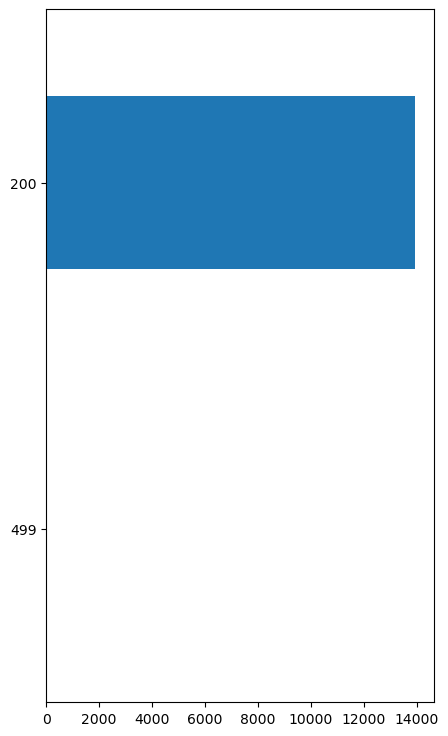

In [32]:
st_co_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [33]:
status_given_st_co = (
    df.groupby('size')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_st_co')
    .reset_index()
)
status_given_st_co.head()

,size,status_code,proba_status_given_st_co
0,0,499,1.0
1,42,200,1.0
2,48,200,1.0
3,126,200,1.0
4,162,200,1.0


In [34]:
status_given_st_co[status_given_st_co.status_code != '200']

,size,status_code,proba_status_given_st_co
0,0,499,1.0


In [35]:
status_given_st_co[status_given_st_co.proba_status_given_st_co < 1]

,size,status_code,proba_status_given_st_co


In [36]:
df.groupby(['ip', 'size']).size()

ip              size  
173.173.113.51  42         1
                348        1
                1328      54
                1787      62
                3561      64
                          ..
97.105.19.58    512773    53
                513027    57
                513236    52
                513313    55
                513736    56
Length: 745, dtype: int64

In [37]:
p_a_and_b = df.groupby(['ip', 'status_code']).size()
p_a_and_b

ip              status_code
173.173.113.51  200             1059
24.26.242.9     200               21
3.88.129.158    200                1
3.92.201.136    200                1
34.207.64.242   200                1
34.229.70.250   200                1
35.174.209.2    200                1
35.175.171.137  200                2
45.23.250.16    200                1
52.87.230.102   200                2
52.90.165.200   200                1
52.91.30.150    200                1
54.145.52.184   200                1
54.172.14.223   200                1
68.201.219.223  200               21
70.121.214.34   200                2
72.181.105.81   200              246
72.181.113.170  200              611
                499                2
97.105.19.58    200            11984
                499               14
dtype: int64

In [38]:
p_a_and_b = df.groupby(['ip', 'status_code']).size()/len(df)
p_a_and_b

ip              status_code
173.173.113.51  200            0.075784
24.26.242.9     200            0.001503
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
34.229.70.250   200            0.000072
35.174.209.2    200            0.000072
35.175.171.137  200            0.000143
45.23.250.16    200            0.000072
52.87.230.102   200            0.000143
52.90.165.200   200            0.000072
52.91.30.150    200            0.000072
54.145.52.184   200            0.000072
54.172.14.223   200            0.000072
68.201.219.223  200            0.001503
70.121.214.34   200            0.000143
72.181.105.81   200            0.017604
72.181.113.170  200            0.043724
                499            0.000143
97.105.19.58    200            0.857593
                499            0.001002
dtype: float64

In [39]:
p_b = df.groupby('ip').size()/len(df)
p_b

ip
173.173.113.51    0.075784
24.26.242.9       0.001503
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001503
70.121.214.34     0.000143
72.181.105.81     0.017604
72.181.113.170    0.043867
97.105.19.58      0.858595
dtype: float64

In [40]:
p_a_and_b / p_b

ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
97.105.19.58    200            0.998833
                499            0.001167
dtype: float64

In [41]:
# Given a particular ip, what is probability of a certain status code
status_given_ip = (
    df.groupby('ip')\
    .status_code.value_counts(normalize=True)\
    .rename('proba_status_given_ip')\
    .reset_index())
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [42]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
19,97.105.19.58,200,0.998833
20,97.105.19.58,499,0.001167


In [43]:
df[df.ip == '72.181.113.170'].sort_values(by='status_code', ascending=False)

,index,ip,request_path,http_version,status_code,size,user_agent,proba_status_given_ip
timestamp,,,,,,,,
17/Apr/2019 02:48:36,12598,72.181.113.170,/api/v1/sales?page=8,HTTP/1.1,499,0,python-requests/2.21.0,0.003263
17/Apr/2019 03:42:44,13106,72.181.113.170,/api/v1/sales?page=133,HTTP/1.1,499,0,python-requests/2.21.0,0.003263
17/Apr/2019 03:42:17,13084,72.181.113.170,/api/v1/sales?page=120,HTTP/1.1,200,510681,python-requests/2.21.0,0.996737
17/Apr/2019 03:42:01,13072,72.181.113.170,/api/v1/sales?page=113,HTTP/1.1,200,511094,python-requests/2.21.0,0.996737
17/Apr/2019 03:42:03,13074,72.181.113.170,/api/v1/sales?page=114,HTTP/1.1,200,511291,python-requests/2.21.0,0.996737
...,...,...,...,...,...,...,...,...
17/Apr/2019 03:28:07,12815,72.181.113.170,/api/v1/sales?page=100,HTTP/1.1,200,512674,python-requests/2.21.0,0.996737
17/Apr/2019 03:28:08,12816,72.181.113.170,/api/v1/sales?page=101,HTTP/1.1,200,510509,python-requests/2.21.0,0.996737
17/Apr/2019 03:28:11,12817,72.181.113.170,/api/v1/sales?page=102,HTTP/1.1,200,512612,python-requests/2.21.0,0.996737


In [44]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
20,97.105.19.58,499,0.001167


In [45]:
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [48]:
df.http_version.value_counts()

HTTP/1.1    13974
Name: http_version, dtype: int64

In [49]:
df.tail()

,index,ip,request_path,http_version,status_code,size,user_agent,proba_status_given_ip_x,proba_status_given_ip_y
timestamp,,,,,,,,,
17/Apr/2019 12:55:12,13969,97.105.19.58,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0,0.998833,0.998833
17/Apr/2019 12:55:12,13970,97.105.19.58,/api/v1/sales?page=65,HTTP/1.1,200,511201,python-requests/2.21.0,0.998833,0.998833
17/Apr/2019 12:55:13,13971,97.105.19.58,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0,0.998833,0.998833
17/Apr/2019 12:55:13,13972,97.105.19.58,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0,0.998833,0.998833
17/Apr/2019 12:55:14,13973,97.105.19.58,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0,0.998833,0.998833


In [50]:
df.index.value_counts()

16/Apr/2019 19:56:10    9
16/Apr/2019 19:49:58    8
16/Apr/2019 20:01:30    7
16/Apr/2019 20:12:23    6
16/Apr/2019 20:02:59    6
                       ..
16/Apr/2019 21:10:09    1
16/Apr/2019 21:10:07    1
16/Apr/2019 21:10:05    1
16/Apr/2019 21:10:03    1
17/Apr/2019 12:55:14    1
Name: timestamp, Length: 9953, dtype: int64